In [ ]:
!pip install qiskit
!pip install qiskit_dynamics
!pip install jax

## 1. Configure Dynamics to use JAX

In [ ]:
# Configure to use JAX internally
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
from qiskit_dynamics.array import Array
Array.set_default_backend("jax")

## Parameter Constants

In [ ]:
import numpy as np

## Chip Parameters
wq = 4.9
T1 = 50*1e3
T2p = 50*1e3
anharm1 = -0.32

wr = 6.4
kappa = 0.012
nth = 0.002

J = 0.100

## Solver setting
dt = 0.1

## Control Parameters
wd = wr
Trd = 250
Tdecay = 50

amp_rd = 0.24

## 2. Instantiating a minimally-configured DynamicsBackend with a JC model

In [ ]:
dimq = 3
dimc = 15

v0 = wr
v1 = wq

ac = np.diag(np.sqrt(np.arange(1, dimc)), 1)
acdag = np.diag(np.sqrt(np.arange(1, dimc)), -1)
Nc = np.diag(np.arange(dimc))

aq = np.diag(np.sqrt(np.arange(1, dimq)), 1)
aqdag = np.diag(np.sqrt(np.arange(1, dimq)), -1)
Nq = np.diag(np.arange(dimq))

Iq = np.eye(dimq, dtype=complex)
Ic = np.eye(dimc, dtype=complex)
full_ident = np.eye(dimc*dimq, dtype=complex)

In [ ]:
N0 = np.kron(Nc, Iq)
N1 = np.kron(Ic, Nq)

a0 = np.kron(ac, Iq)
a1 = np.kron(Ic, aq)

a0dag = np.kron(acdag, Iq)
a1dag = np.kron(Ic, aqdag)

static_ham0 = 2*np.pi * v0 * N0
static_ham1 = 2*np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

# Include non-RWA terms here
static_ham_full = static_ham0 + static_ham1 + 2*np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2*np.pi * 1j*np.sqrt(kappa) * (a0 - a0dag)
r1 = 0.26
drive_op1 = 2*np.pi * r1 * (a1 + a1dag)

c_ops = [np.sqrt(2*np.pi*kappa*(1+nth))*a0, np.sqrt(2*np.pi*kappa*nth)*a0dag, np.sqrt(2*np.pi*1/T1)*a1] #, np.sqrt(2*np.pi*1/T2p/2)*N1]

### Characteristic time

In [ ]:
1/kappa

83.33333333333333

### Purcell Effect Limit

In [ ]:
T1_purcell = 1/( kappa * J**2/(v0-v1)**2 )
T1_purcell*1e-3

18.749999999999996

### Predict the Signal-to-noise Ratio by $2\chi/\kappa$

In [ ]:
# critical photon numbers
n_crit = (v0-v1)**2/(4*J**2)
print('Critical photon number is :', n_crit)

chi01 = -J**2/(v1-v0)  # MHz
chi12 = -2*J**2/(v1+anharm1-v0)
print('The first order dispersive shift:  ', chi01*1e3, ' MHz')
chi = J**2/(v1-v0) * 1/(1+ (v1-v0)/anharm1)        # GHz
print(r'The effective dispersive shift:  ', chi * 1e3, ' MHz')
k = -2*chi/(kappa)
print('Ratio k=', k)
print('Dispersive regime? ->', J/(v0-v1))

Critical photon number is : 56.249999999999986
The first order dispersive shift:   6.666666666666668  MHz
The effective dispersive shift:   -1.1721611721611724  MHz
Ratio k= 0.1953601953601954
Dispersive regime? -> 0.06666666666666667


In [ ]:
chi12/3

0.0036630036630036634

## 3. Define Solver

In [ ]:
from qiskit_dynamics import Solver
from qiskit_dynamics.models import RotatingFrame

# build solver
vd = wd + 0.004

solver = Solver(
    static_hamiltonian = static_ham_full,
    hamiltonian_operators = [drive_op0, drive_op1],
    rotating_frame = 2*np.pi * vd*N0 + 2*np.pi * vd*N1,
    in_frame_basis = False,
    static_dissipators = c_ops,
    dt=dt,
)

## 4. Pulse Schedule

In [ ]:
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit import pulse

Tgate = 20
duration1 = int(Tgate/dt)
duration2 = int(Trd/dt)
duration3 = int(Tdecay/dt)

#freq = 0.5 / duration1
phase = np.pi/2
angle = 0

carriers = {'d0': vd, 'd1': v1-chi01}

with pulse.build(name="Single-shot Readout schedule") as xp0:
    pulse.delay(duration=duration1+duration2+duration3, channel=pulse.DriveChannel(1))
    pulse.delay(duration=duration1, channel=pulse.DriveChannel(0))
    #pulse.shift_phase(-np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Constant(duration=duration2, amp=amp_rd), pulse.DriveChannel(0))
    pulse.delay(duration=duration3, channel=pulse.DriveChannel(0))
convert = InstructionToSignals(dt, carriers=carriers)
signals0 = convert.get_signals(xp0)

## 5.Solve Dynamics

In [ ]:
from qiskit.quantum_info import Statevector, Operator, DensityMatrix

t_final = Tgate+Trd+Tdecay
t_eval = np.linspace(0., t_final, int(t_final/dt)+1)

# A density matrix with all qubits in ground state
statec = Statevector.from_int(0, dimc)
stateq0 = Statevector.from_int(0, dimq)
stateq1 = Statevector.from_int(1, dimq)
y0 = statec^stateq0
y1 = statec^stateq1

In [ ]:
sol1 = solver.solve(t_eval=t_eval, t_span=[0., t_final], y0=y1, method='jax_RK4', signals=signals0, max_dt=dt/5)
sol0 = solver.solve(t_eval=t_eval, t_span=[0., t_final], y0=y0, method='jax_RK4', signals=signals0, max_dt=dt/5)

# 6. Signal Processing

In [236]:
from scipy.linalg import helmert
from numpy.matlib import repmat
from scipy.cluster.vq import kmeans2

def amplifier_operation(field1, field0, n1, n2, t_list, var=1/np.sqrt(2), repeat=1000, eta_amp=0.45, gain_dB=20):
    t_samples_list = t_list[n1:n2]
    sample_field1 = field1[n1:n2]; sample_field0 = field0[n1:n2]
    sample_width = len(t_samples_list)

    alpha1, alpha0 = np.absolute(sample_field1[-1]), np.absolute(sample_field0[-1]);
    theta1, theta0 = np.angle(field1[-1]), np.angle(field0[-1])
    var_theta1, var_theta0 = var**2/alpha1, var**2/alpha0
    noisy_field1 = (
        repmat((field1[n1:n2] - alpha1*np.exp(1j*theta1)) , repeat, 1) +
        np.random.poisson(alpha1, size=(repeat, sample_width))*np.exp(
            1j*np.random.normal(theta1, var_theta1, (repeat, sample_width))
            )
    )
    noisy_field0 = (
        repmat((field0[n1:n2] - alpha0*np.exp(1j*theta0)) , repeat, 1) +
        np.random.poisson(alpha0, size=(repeat, sample_width))*np.exp(
            1j*np.random.normal(theta0, var_theta0, (repeat, sample_width))
            )
    )
    ratio1 = ( kappa/2 - 1j*((vd-v0)-chi) )/np.sqrt(kappa)
    ratio0 = ( kappa/2 - 1j*((vd-v0)+chi) )/np.sqrt(kappa)
    RF_out_1 = ratio1 * sample_field1  ## Input-output relationship
    RF_out_0 = ratio0 * sample_field0

    def dB_conversion(signal, dB):
        '''Amplitude conversion by dB'''
        return signal*10**(dB/20)

    def apply_amplifier(signal, gain_dB, added_photon, repeat, sample_width, ratio=1):
        G = 10**(gain_dB/20)
        A = (G-1)/G * (added_photon + 1/2) * ratio ## add np.sqrt(kappa) here to express noise power in the new phase space
        sigma = np.sqrt(A*G/(G-1))
        new_signal = (
            np.sqrt(G)*signal +
            (np.sqrt(G*A)*np.random.normal(0, sigma, (repeat, sample_width)) +
            1j*np.sqrt(G*A)*np.random.normal(0, sigma, (repeat, sample_width)))
        )
        return new_signal

    HEMT_amplified_RF1 = apply_amplifier(RF_out_1, 40, 5, repeat, sample_width, ratio=np.abs(ratio1))
    HEMT_amplified_RF0 = apply_amplifier(RF_out_0, 40, 5, repeat, sample_width, ratio=np.abs(ratio0))

    IMPA_amplified_RF1 = apply_amplifier(
        apply_amplifier(RF_out_1, 25, 0.02, repeat, sample_width, ratio=np.abs(ratio1)),
        40, 10, repeat, sample_width, ratio=np.abs(ratio1),
    )
    IMPA_amplified_RF0 = apply_amplifier(
        apply_amplifier(RF_out_0, 25, 0.02, repeat, sample_width, ratio=np.abs(ratio0)),
        40, 10, repeat, sample_width, ratio=np.abs(ratio0),
    )

    return (IMPA_amplified_RF1.sum(axis=1)/sample_width,
            IMPA_amplified_RF0.sum(axis=1)/sample_width,
            HEMT_amplified_RF1.sum(axis=1)/sample_width,
            HEMT_amplified_RF0.sum(axis=1)/sample_width
    )

def apply_classifier(data1, data0):
    X0 = np.array([np.real(data0), np.imag(data0)]).T
    X1 = np.array([np.real(data1), np.imag(data1)]).T

    X = np.concatenate((X0, X1))
    centroids, labels = kmeans2(X, 2)
    w0 = X[labels == 0]
    w1 = X[labels == 1]
    return w1, w0, centroids

## 7.Visualization

### Photon numbers

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


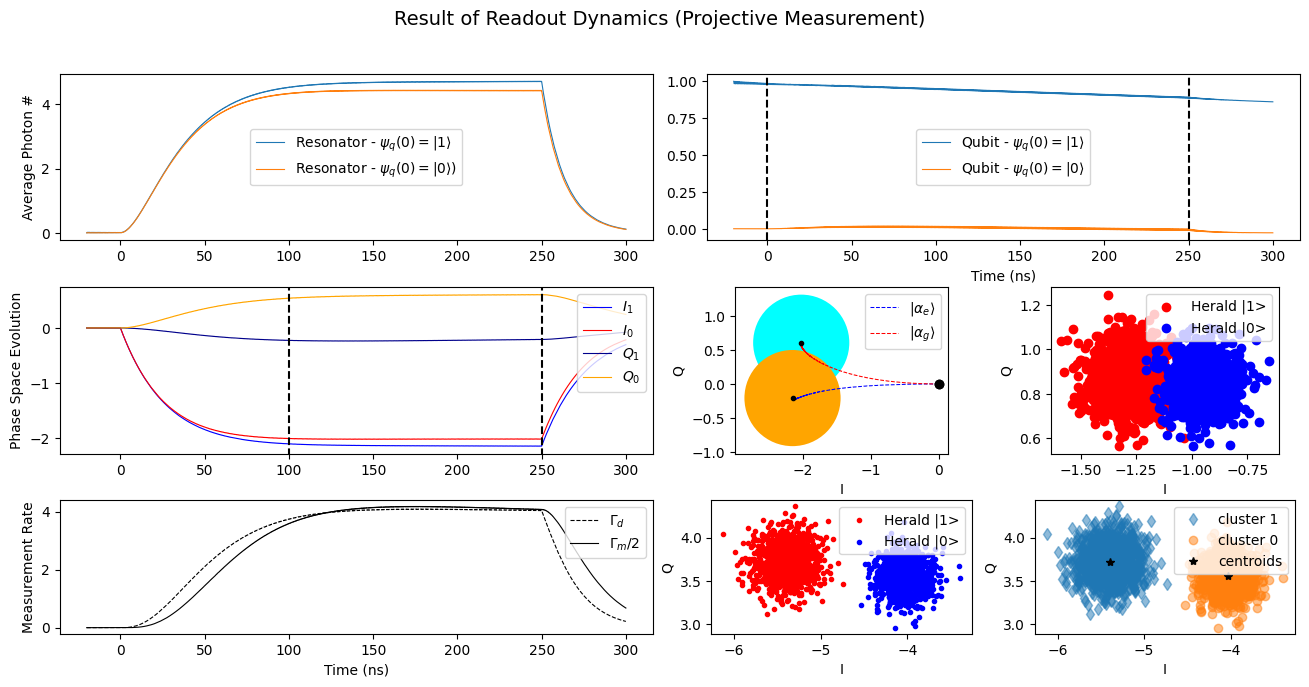

In [240]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle

def plot_readout_dynamics(sol1, sol0):
    '''Plot'''

    popNc1 = [psi.expectation_value(Operator(N0, (dimq,dimc), (dimq,dimc))) for psi in sol1.y]
    popNq1 = [psi.expectation_value(Operator(N1, (dimq,dimc), (dimq,dimc))) for psi in sol1.y]
    popNc0 = [psi.expectation_value(Operator(N0, (dimq,dimc), (dimq,dimc))) for psi in sol0.y]
    popNq0 = [psi.expectation_value(Operator(N1, (dimq,dimc), (dimq,dimc))) for psi in sol0.y]
    xc1 = [np.real(psi.expectation_value(Operator(a0, (dimq,dimc), (dimq,dimc)))) for psi in sol1.y]
    yc1 = [np.imag(psi.expectation_value(Operator(a0, (dimq,dimc), (dimq,dimc)))) for psi in sol1.y]
    xc0 = [np.real(psi.expectation_value(Operator(a0, (dimq,dimc), (dimq,dimc)))) for psi in sol0.y]
    yc0 = [np.imag(psi.expectation_value(Operator(a0, (dimq,dimc), (dimq,dimc)))) for psi in sol0.y]

    Ave_ac1 = np.array(xc1)+1j*np.array(yc1)
    Ave_ac0 = np.array(xc0)+1j*np.array(yc0)
    Gamma_d = 2*chi*1e3*np.imag( Ave_ac0*np.conjugate(Ave_ac1) )
    Gamma_m = kappa*1e3*(np.absolute(Ave_ac1-Ave_ac0))**2

    n1 = int((Tgate+100)/dt)
    n2 = int((Tgate+250)/dt)

    fig = plt.figure(figsize=(16,8))
    fig.suptitle("Result of Readout Dynamics (Projective Measurement)", fontsize=14)
    gs = GridSpec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 0.8], top=0.9, bottom=0.2, wspace=0.2, hspace=0.3)
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, 2:])
    ax3 = fig.add_subplot(gs[1, :2])
    ax4 = fig.add_subplot(gs[2, :2])
    #ax5 = fig.add_subplot(gs[3, :2])
    ax6 = fig.add_subplot(gs[1, 2])
    ax7 = fig.add_subplot(gs[1, 3])
    ax8 = fig.add_subplot(gs[2:, 2])
    ax9 = fig.add_subplot(gs[2:, 3])

    ax1.plot(sol1.t-Tgate, popNc1, lw=0.8, label=r"Resonator - $\psi_{q}(0)=|1\rangle$")
    ax1.plot(sol0.t-Tgate, popNc0, lw=0.8, label=r"Resonator - $\psi_{q}(0)=|0\rangle$)")
    ax1.set_ylabel("Average Photon #")
    ax1.legend(loc='center')

    ax2.plot(sol1.t-Tgate, popNq1, lw=0.8, label=r"Qubit - $\psi_{q}(0)=|1\rangle$")
    ax2.plot(sol0.t-Tgate, popNq0, lw=0.8, label=r"Qubit - $\psi_{q}(0)=|0\rangle$")
    ax2.axvline(ymax=1.1, color='black', linestyle='--')
    ax2.axvline(x=Trd, ymax=1.1, color='black', linestyle='--')
    ax2.set_xlabel("Time (ns)")
    ax2.legend(loc='center')

    ax3.plot(sol1.t-Tgate, xc1, lw=0.8, label=r"$I_{1}$", color='blue')
    ax3.plot(sol1.t-Tgate, xc0, lw=0.8, label=r"$I_{0}$", color='red')
    ax3.plot(sol1.t-Tgate, yc1, lw=0.8, label=r"$Q_{1}$", color='darkblue')
    ax3.plot(sol1.t-Tgate, yc0, lw=0.8, label=r"$Q_{0}$", color='orange')
    ax3.axvline(x=n1*dt-Tgate, ymax=5, ymin=-5, color='black', linestyle='--')
    ax3.axvline(x=n2*dt-Tgate, ymax=5, ymin=-5, color='black', linestyle='--')
    ax3.set_ylabel("Phase Space Evolution")
    ax3.legend(loc='upper right')

    ax4.plot(sol1.t-Tgate, np.absolute(Gamma_d), lw=0.8, linestyle='--', color='black', label=r"$\Gamma_{d}$")
    ax4.plot(sol1.t-Tgate, Gamma_m/2, lw=0.8, color='black', label=r"$\Gamma_{m}/2$")
    ax4.set_ylabel("Measurement Rate")
    ax4.set_xlabel("Time (ns)")
    ax4.legend(loc='upper right')

    ax6.plot(xc1[int(Tgate/dt):int((Tgate+Trd)/dt)], yc1[int(Tgate/dt):int((Tgate+Trd)/dt)], '--', linewidth=0.75, color='blue', label=r'$|\alpha_{e}\rangle$')
    ax6.plot(xc0[int(Tgate/dt):int((Tgate+Trd)/dt)], yc0[int(Tgate/dt):int((Tgate+Trd)/dt)], '--', linewidth=0.75, color='red', label=r'$|\alpha_{g}\rangle$')
    ax6.plot(xc1[int(Tgate/dt)], yc1[int(Tgate/dt)], marker='o', color='black')
    ax6.plot(xc0[int(Tgate/dt)], yc0[int(Tgate/dt)], marker='o', color='black')
    end_x0, end_y0 = xc0[int((Tgate+Trd)/dt)], yc0[int((Tgate+Trd)/dt)]
    end_x1, end_y1 = xc1[int((Tgate+Trd)/dt)], yc1[int((Tgate+Trd)/dt)]
    circle0 = Circle(xy=(end_x0, end_y0), radius=1/np.sqrt(2), facecolor='cyan')
    circle1 = Circle(xy=(end_x1, end_y1), radius=1/np.sqrt(2), facecolor='orange')
    ax6.add_patch(circle0)
    ax6.add_patch(circle1)
    ax6.plot(end_x0, end_y0, marker='.', color='black')
    ax6.plot(end_x1, end_y1, marker='.', color='black')
    ax6.set_ylabel('Q')
    ax6.set_xlabel('I')
    ax6.set_aspect('equal')
    ax6.legend()

    data1, data0, data1_, data0_ = amplifier_operation(Ave_ac1, Ave_ac0, n1, n2, sol1.t, repeat=1000, gain_dB=40)

    ax7.scatter(np.real(data1_), np.imag(data1_), color='red', label='Herald |1>' )
    ax7.scatter(np.real(data0_), np.imag(data0_), color='blue', label='Herald |0>' )
    ax7.set_ylabel('Q')
    ax7.set_xlabel('I')
    ax7.set_aspect('equal')
    ax7.legend()

    ax8.scatter(np.real(data1), np.imag(data1), marker='.', color='red', label='Herald |1>' )
    ax8.scatter(np.real(data0), np.imag(data0), marker='.', color='blue', label='Herald |0>' )
    ax8.set_ylabel('Q')
    ax8.set_xlabel('I')
    ax8.set_aspect('equal')
    ax8.legend()

    cluster1, cluster0, centroids = apply_classifier(data1, data0)
    ax9.plot(cluster1[:, 0], cluster1[:, 1], 'd', alpha=0.5, label='cluster 1')
    ax9.plot(cluster0[:, 0], cluster0[:, 1], 'o', alpha=0.5, label='cluster 0')
    ax9.plot(centroids[:, 0], centroids[:, 1], 'k*', label='centroids')
    ax9.set_ylabel('Q')
    ax9.set_xlabel('I')
    ax9.set_aspect('equal')
    ax9.legend()

plot_readout_dynamics(sol1, sol0)

## 7.Summary: Important quantities to calculate

* Measurement-induced qubit dephasing rate: $Γ_{d}=2\chi \mathrm{Im}(\alpha_{g}\alpha_{e}^{*})$
* Maximum measurement rate: $\Gamma_{m}(t)=\kappa|\beta(t)|^2=\kappa(\alpha_{e}
-\alpha_{g})(\alpha^{*}_{e}-\alpha^{*}_{g})$
* Amplification gain and added noise: $\sqrt{G}$, $ξ$
* Monitored record: $V_{i}$
* Integrated Voltage: $V_{m}$
* Measurement efficiency: $η_{m}=\eta_{col} \eta_{amp}=\frac{\kappa_{out}}{\kappa_{in}+\kappa_{out}}\eta_{amp}$, where we have assumed $\kappa_{in}\approx 0$
* Total quantum efficiency: $η=\eta_{m} \eta_{env}$
* Signal-to-noise ratio: SNR

### Output Field Signal
The input-outout relationship gives rise to the boundary condition for the EM fields between readout resonator and the feedline:
$$
c_{in}(t)-c_{out}(t)= \sqrt{κ}a(t)
$$
Further we combine this condition to the Quantum Langevin euqaiton of optical cavity, we can derive the relationship between $c_{out}$ and $a$:
$$
c_{out}(t)=\frac{\frac{\kappa}{2}-i(Δ-χ_{\mathrm{eff}} σ_{z})}{\frac{\kappa}{2}+i(Δ-χ_{\mathrm{eff}} σ_{z})}c_{in}(t)=\frac{\frac{\kappa}{2}-i(Δ-χ_{\mathrm{eff}} σ_{z})}{\sqrt{\kappa}}a(t)
$$
The classical part of the output field is the expectation of the field:
$$
\langle c_{out}(t)\rangle=\frac{\frac{\kappa}{2}-i(Δ-χ_{\mathrm{eff}} σ_{z})}{\sqrt{\kappa}}\langle a(t)⟩
$$
The quantum noise of output field are governed by:
$$
\langle c_{out}(t^{\prime}), c_{out}(t)\rangle = \kappa\langle a(t^{\prime}), a(t)\rangle,
$$
where the $\langle U, V\rangle=\langle UV\rangle -\langle U\rangle\langle V\rangle$.

### Amplification Chain

This process can be simply expressed as:
$$b(t)=\sqrt{G}c_{out}(t)+\xi^{†}(t)$$
Without loss of generality, we consider $\xi$ only consists of white noise with effective temperature $T_{\mathrm{eff}}≈\hbar\omega_{r}/k_{B}$, approaching the quantum limit ~1/2. This strenth of noise approximately corresponds to half a photon. The white noise is the effect of the cascaded amplifier series up to room temperature channel.

i.e. The gain, strength of the noise is determined by IMPA, but the distribution is simply Gasussian.

* IMPA: G ~ 20dB, $\langle h^{\dagger}h\rangle$ ~ 0
* HEMT: G ~ 20dB, $\langle h^{\dagger}h\rangle$ ~ 5

In [173]:
def evaluate_readout_dynamics():
    sol1 = solver.solve(t_eval=t_eval, t_span=[0., t_final], y0=y1, method='jax_RK4', signals=signals0, max_dt=dt/5)
    sol0 = solver.solve(t_eval=t_eval, t_span=[0., t_final], y0=y0, method='jax_RK4', signals=signals0, max_dt=dt/5)

    plot_readout_dynamics(sol1, sol0)